# Derivados Financieros 2022 - Clase 3



Plan de la clase:

    1) Modelo Binomial
    2) Modificacion para ejercicio temprano (Americanas)
    3) Jugando con el pricer
    4) Black Scholes
    5) Mercado vs Modelo

## 1) Modelo Binomial

In [2]:
import math
import numpy as np

import sys
sys.path.append('..')

from Codigo.opcion_europea_bin import opcion_europea_bin
from Codigo.opcion_europea_bin_c import opcion_europea_bin_c
from Codigo.opcion_americana_bin import opcion_americana_bin
from Codigo.opcion_europea_bs import opcion_europea_bs



Definicion:
    Calculador del precio de una opcion Europea con el modelo del Arbol Binomial (CRR)

Inputs:
    - tipo : string - Tipo de contrato entre ["CALL","PUT"]
    - S : float - Spot price del activo
    - K : float - Strike price del contrato
    - T : float - Tiempo hasta la expiracion (en años)
    - r : float - Tasa 'libre de riesgo' (anualizada)
    - sigma : float - Volatilidad implicita (anualizada)
    - div : float - Tasa de dividendos continuos (anualizada)
    - pasos : int - Cantidad de pasos del arbol binomial

Outputs:
    - precio_BIN: float - Precio del contrato


In [3]:
#Paramtros del metodo

tipo = "C"
S = 100
K = 100
T = 1
r = 0.05
sigma = 0.25
div = 0
pasos = 20


precio = opcion_europea_bin(tipo, S, K, T, r, sigma, div, pasos)
precio

12.213215959513816

## Desglosando el metodo

### 1) Inicializo los parametros

In [4]:
tipo = "C"
S = 100
K = 100
T = 1
r = 0.05
sigma = 0.25
div = 0
pasos = 3

### 2) Variables auxiliares

In [5]:
#auxiliares
dt = T / pasos
tasa_forward = math.exp((r - div) * dt)
descuento = math.exp(-r * dt)


### 3) Parametros del Modelo (en este caso el CRR)

In [6]:
#modelo CRR
u = math.exp(sigma * math.pow(dt, 0.5))
d = 1 / u

#probabilidad de riesgo neutral
q_prob = (tasa_forward - d) / (u - d)

q_prob


0.5219953022055941

### 4) Vector de precios finales (ultima rama del arbol)

In [7]:
#Precios finales
ST_precios=np.zeros((pasos+1))

for i in range(0,pasos+1):
    ST_precios[pasos-i] = math.pow(u, 2 * i - pasos) * S
    
ST_precios

array([154.18958056, 115.52740254,  86.5595502 ,  64.85522539])

### 5) Matriz (representa el arbol) de precios de la opcion -  la ultima columna representa el Payoff

In [8]:
from pprint import pprint as pp
#Matriz de precios de la opcion
opcion_precios = np.zeros((pasos+1, pasos+1))

opcion_precios

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [9]:
#Payoff
for i in range (0, pasos+1):
    if tipo == "P":
        opcion_precios[i][pasos] = max(0, (K - ST_precios[i]))
    elif tipo == "C":
        opcion_precios[i][pasos] = max(0, (ST_precios[i] - K))
        
pp(opcion_precios)

array([[ 0.        ,  0.        ,  0.        , 54.18958056],
       [ 0.        ,  0.        ,  0.        , 15.52740254],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ]])


### 6) Recorro el arbol columna por columna

In [10]:
j = 1
for i in range(0, pasos+1 - j):
    opcion_precios[i][pasos - j] = descuento * (q_prob * opcion_precios[i][pasos - j + 1] + (1  - q_prob) * opcion_precios[i + 1][pasos - j + 1])

opcion_precios   

array([[ 0.        ,  0.        , 35.118662  , 54.18958056],
       [ 0.        ,  0.        ,  7.9712635 , 15.52740254],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ]])

In [11]:
j = 2
for i in range(0, pasos+1 - j):
    opcion_precios[i][pasos - j] = descuento * (q_prob * opcion_precios[i][pasos - j + 1] + (1  - q_prob) * opcion_precios[i + 1][pasos - j + 1])

opcion_precios 

array([[ 0.        , 21.77610163, 35.118662  , 54.18958056],
       [ 0.        ,  4.09218744,  7.9712635 , 15.52740254],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ]])

In [12]:
j = 3
for i in range(0, pasos+1 - j):
    opcion_precios[i][pasos - j] = descuento * (q_prob * opcion_precios[i][pasos - j + 1] + (1  - q_prob) * opcion_precios[i + 1][pasos - j + 1])

opcion_precios 

array([[13.10289597, 21.77610163, 35.118662  , 54.18958056],
       [ 0.        ,  4.09218744,  7.9712635 , 15.52740254],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ]])

### 7) Precio de la opcion, primer nodo del arbol 

In [13]:
precio_BIN_eur = opcion_precios[0][0]
pp(precio_BIN_eur)

13.102895972137345


## Formula Cerrada

Volvemos a inicializar todas las variables


In [14]:
import operator as op
from functools import reduce
def ncr(n, r):
    r = min(r, n-r)
    numer = reduce(op.mul, range(n, n-r, -1), 1)
    denom = reduce(op.mul, range(1, r+1), 1)
    return numer // denom  # or / in Python 2


def nCr(n, r):
    f = math.factorial
    return f(n) / f(r) / f(n - r)

In [15]:
tipo = "C"
S = 100
K = 100
T = 1
r = 0.05
sigma = 0.25
div = 0
pasos = 1000


#auxiliares
dt = T / pasos
tasa_forward = math.exp((r - div) * dt)
descuento = math.exp(-r * dt)

#modelo CRR
u = math.exp(sigma * math.pow(dt, 0.5))
d = 1 / u
#probabilidad de riesgo neutral
q_prob = (tasa_forward - d) / (u - d)


In [16]:
temp = 0

for k in range(pasos):
    if tipo == "C":
        payoff = max(0, S * math.pow(u,k) * math.pow(d,pasos-k)-K)
    elif tipo == "P":
        payoff = max(0, K - S * math.pow(u, k) * math.pow(d, pasos - k))
    temp = temp +ncr(pasos, k) * math.pow(q_prob,k) * math.pow((1-q_prob),pasos-k) * payoff

precio_BIN_c = math.exp(-r*T)*temp
    
precio_BIN_c

12.333527192230562

## 2) Americana

In [17]:
tipo = "C"
S = 100
K = 100
T = 1
r = 0.05
sigma = 0.25
div = 0
pasos = 1000


#auxiliares
dt = T / pasos
tasa_forward = math.exp((r - div) * dt)
descuento = math.exp(-r * dt)
#modelo CRR
u = math.exp(sigma * math.pow(dt, 0.5))
d = 1 / u
#probabilidad de riesgo neutral
q_prob = (tasa_forward - d) / (u - d)


#Precios finales
ST_precios=np.zeros((pasos+1))

for i in range(0,pasos+1):
    ST_precios[pasos-i] = math.pow(u, 2 * i - pasos) * S
    
ST_precios
opcion_precios = np.zeros((pasos+1, pasos+1))




En el caso de una opcion americana, en cada punto del nodo tendremos que evaluar si nos conviene ejercer o no. Eso se resuelve de manera muy simple.

In [18]:
for j in range(1, pasos+1):
    for i in range(0, pasos+1 - j):
        # Calculo primero el valor como si no hubiera ejercicio temprano (europeo)
        eur = q_prob * opcion_precios[i][pasos - j + 1] + (1  - q_prob) * opcion_precios[i + 1][pasos - j + 1]
        #dependiendo del contrato, comparo el valor del valor 'europeo' contra ejercer en ese momento.
        # S * math.pow(u,-2*i+pasos-j) codifica al arbol de los S
        if tipo == "P":
            opcion_precios[i][pasos - j] = descuento * max(eur, K - S * math.pow(u,-2*i+pasos-j))
        elif tipo == "C":
            opcion_precios[i][pasos - j] = descuento * max(eur, S * math.pow(u,-2*i+pasos-j) - K)

precio_BIN_ame = opcion_precios[0][0]
pp(precio_BIN_ame) 



12.33039037544276


# 3) Jugando con el pricer

In [19]:
import matplotlib.pyplot as plt

## Precio y payoff con respecto a S

In [20]:
tipo = "C"
S = 100
K = 100
T = 1
r = 0.05
sigma= 0.25
div =0
pasos = 1000

S_MAX = 2*S
S_vec = np.linspace(0,S_MAX,50)      
precios = np.zeros(len(S_vec))
payoff = np.zeros(len(S_vec))



S_vec 


array([  0.        ,   4.08163265,   8.16326531,  12.24489796,
        16.32653061,  20.40816327,  24.48979592,  28.57142857,
        32.65306122,  36.73469388,  40.81632653,  44.89795918,
        48.97959184,  53.06122449,  57.14285714,  61.2244898 ,
        65.30612245,  69.3877551 ,  73.46938776,  77.55102041,
        81.63265306,  85.71428571,  89.79591837,  93.87755102,
        97.95918367, 102.04081633, 106.12244898, 110.20408163,
       114.28571429, 118.36734694, 122.44897959, 126.53061224,
       130.6122449 , 134.69387755, 138.7755102 , 142.85714286,
       146.93877551, 151.02040816, 155.10204082, 159.18367347,
       163.26530612, 167.34693878, 171.42857143, 175.51020408,
       179.59183673, 183.67346939, 187.75510204, 191.83673469,
       195.91836735, 200.        ])

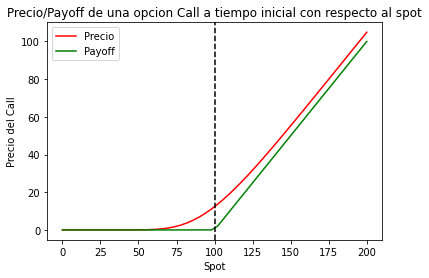

In [21]:
for index in range(len(S_vec)):
    precios[index] = opcion_europea_bin(tipo, S_vec[index], K, T, r, sigma, div, pasos)
    payoff[index] = max(0, S_vec[index]-K)
plt.plot(S_vec,precios,'r', label='Precio')
plt.plot(S_vec,payoff,'g', label='Payoff')
plt.axvline(x=K, color = 'black', linestyle='--')

plt.legend()

plt.xlabel('Spot')
plt.ylabel('Precio del Call')
plt.title('Precio/Payoff de una opcion Call a tiempo inicial con respecto al spot')

plt.show()

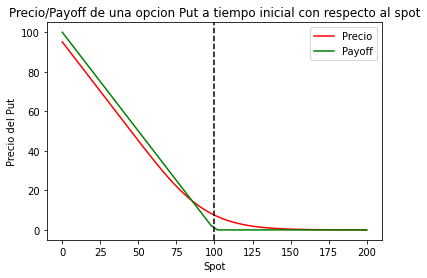

In [22]:
tipo = "P"
S = 100
K = 100
T = 1
r = 0.05
sigma= 0.25
div =0
pasos = 1000

S_MAX = 2*S
S_vec = np.linspace(0,S_MAX,50)      
precios = np.zeros(len(S_vec))
payoff = np.zeros(len(S_vec))




for index in range(len(S_vec)):
    precios[index] = opcion_europea_bin_c(tipo, S_vec[index], K, T, r, sigma, div, pasos)
    payoff[index] = max(0, K-S_vec[index])
plt.plot(S_vec,precios,'r', label='Precio')
plt.plot(S_vec,payoff,'g', label='Payoff')
plt.axvline(x=K, color = 'black', linestyle='--')

plt.legend()

plt.xlabel('Spot')
plt.ylabel('Precio del Put')
plt.title('Precio/Payoff de una opcion Put a tiempo inicial con respecto al spot')

plt.show()

In [23]:
S_vec

array([  0.        ,   4.08163265,   8.16326531,  12.24489796,
        16.32653061,  20.40816327,  24.48979592,  28.57142857,
        32.65306122,  36.73469388,  40.81632653,  44.89795918,
        48.97959184,  53.06122449,  57.14285714,  61.2244898 ,
        65.30612245,  69.3877551 ,  73.46938776,  77.55102041,
        81.63265306,  85.71428571,  89.79591837,  93.87755102,
        97.95918367, 102.04081633, 106.12244898, 110.20408163,
       114.28571429, 118.36734694, 122.44897959, 126.53061224,
       130.6122449 , 134.69387755, 138.7755102 , 142.85714286,
       146.93877551, 151.02040816, 155.10204082, 159.18367347,
       163.26530612, 167.34693878, 171.42857143, 175.51020408,
       179.59183673, 183.67346939, 187.75510204, 191.83673469,
       195.91836735, 200.        ])

## Precio con respecto al Strike

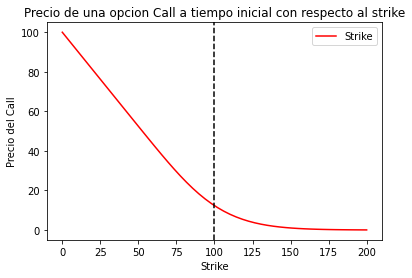

In [24]:
tipo = "C"
S = 100
K = 100
T = 1
r = 0.05
sigma= 0.25
div =0
pasos = 1000

K_MAX = 2*S
K_vec = np.linspace(0,K_MAX,50)      
precios = np.zeros(len(K_vec))




for index in range(len(K_vec)):
    precios[index] = opcion_europea_bin_c(tipo, S, K_vec[index], T, r, sigma, div, pasos)

plt.plot(K_vec,precios,'r', label='Strike')
plt.axvline(x=S, color = 'black', linestyle='--')

plt.legend()

plt.xlabel('Strike')
plt.ylabel('Precio del Call')
plt.title('Precio de una opcion Call a tiempo inicial con respecto al strike')

plt.show()

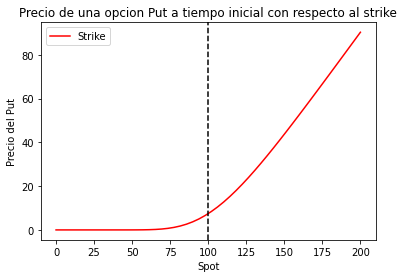

In [25]:
tipo = "P"
S = 100
K = 100
T = 1
r = 0.05
sigma= 0.25
div =0
pasos = 1000

K_MAX = 2*S
K_vec = np.linspace(0,K_MAX,50)      
precios = np.zeros(len(K_vec))
payoff = np.zeros(len(K_vec))




for index in range(len(K_vec)):
    precios[index] = opcion_europea_bin_c(tipo, S, K_vec[index], T, r, sigma, div, pasos)

plt.plot(K_vec,precios,'r', label='Strike')
plt.axvline(x=S, color = 'black', linestyle='--')

plt.legend()

plt.xlabel('Spot')
plt.ylabel('Precio del Put')
plt.title('Precio de una opcion Put a tiempo inicial con respecto al strike')

plt.show()

## Precio con respecto a sigma

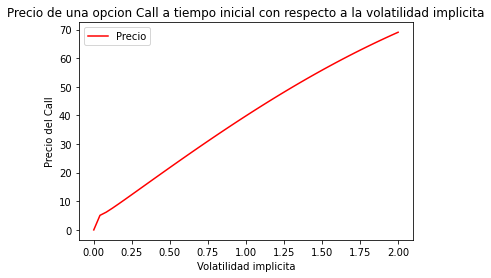

In [26]:
tipo = "C"
S = 100
K = 100
T = 1
r = 0.05
sigma= 0.25
div =0
pasos = 1000

sigma_MAX = 8*sigma
sigma_vec = np.linspace(0,sigma_MAX,50)      
precios = np.zeros(len(sigma_vec))

for index in range(1,len(sigma_vec)):
    precios[index] = opcion_europea_bin_c(tipo, S, K, T, r, sigma_vec[index], div, pasos)
plt.plot(sigma_vec,precios,'r', label='Precio')
plt.legend()

plt.xlabel('Volatilidad implicita')
plt.ylabel('Precio del Call')
plt.title('Precio de una opcion Call a tiempo inicial con respecto a la volatilidad implicita')

plt.show()

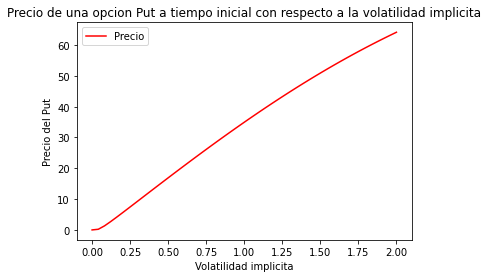

In [27]:
tipo = "P"
S = 100
K = 100
T = 1
r = 0.05
sigma= 0.25
div =0
pasos = 1000

sigma_MAX = 8*sigma
sigma_vec = np.linspace(0,sigma_MAX,50)      
precios = np.zeros(len(sigma_vec))

for index in range(1,len(sigma_vec)):
    precios[index] = opcion_europea_bin_c(tipo, S, K, T, r, sigma_vec[index], div, pasos)
plt.plot(sigma_vec,precios,'r', label='Precio')
plt.legend()

plt.xlabel('Volatilidad implicita')
plt.ylabel('Precio del Put')
plt.title('Precio de una opcion Put a tiempo inicial con respecto a la volatilidad implicita')

plt.show()

## Precio con respecto a TTM

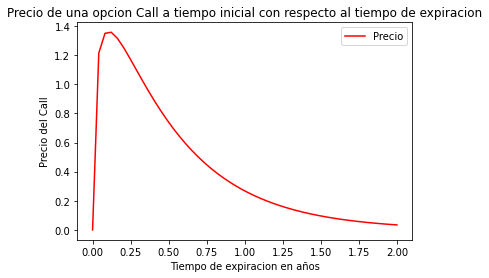

In [28]:
tipo = "C"
S = 100
K = 100
T = 1
r = 0.05
sigma= 0.25
div =0.5
pasos = 1000

T_MAX = 2*T
T_vec = np.linspace(0,T_MAX,50)      
precios = np.zeros(len(T_vec))

for index in range(1,len(T_vec)):
    precios[index] = opcion_europea_bin_c(tipo, S, K, T_vec[index], r, sigma, div, pasos)
plt.plot(T_vec,precios,'r', label='Precio')
plt.legend()

plt.xlabel('Tiempo de expiracion en años')
plt.ylabel('Precio del Call')
plt.title('Precio de una opcion Call a tiempo inicial con respecto al tiempo de expiracion')

plt.show()

## Convergencia del Arbol Binomial

In [29]:
tipo = "C"
S = 100
K = 100
T = 1
r = 0.05
sigma= 0.25
div =0

pasos_vec = [1,2,3,4,5,6,7,8,9,10,12,14,16,18,20,25,30,40,50,75,100,125,150,200,250,300]      
precios = np.zeros(len(pasos_vec))

for index in range(len(pasos_vec)):
    precios[index] = opcion_europea_bin(tipo, S, K, T, r, sigma, div, pasos_vec[index])
    

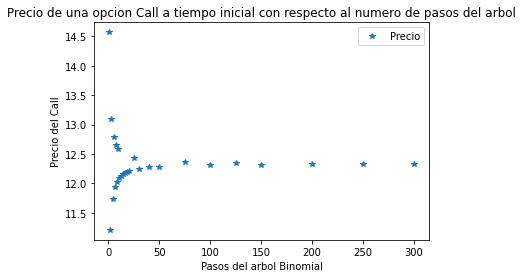

In [30]:
plt.plot(pasos_vec,precios,'*', label='Precio')
plt.legend()

plt.xlabel('Pasos del arbol Binomial')
plt.ylabel('Precio del Call')
plt.title('Precio de una opcion Call a tiempo inicial con respecto al numero de pasos del arbol')

plt.show()

## Europeas - Americanas


### CALL sin dividendos

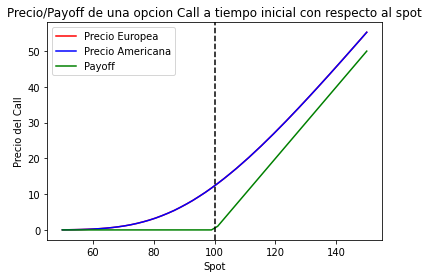

Precio Opcion Europea:  12.323646460707344
Precio Opcion Americana:  12.323646460707344


In [31]:
tipo = "C"
K = 100
T = 1
r = 0.05
sigma= 0.25
div =0
pasos = 200

S_vec = np.linspace(0.5*S,1.5*S,50)      
precios_eur = np.zeros(len(S_vec))
precios_ame = np.zeros(len(S_vec))

payoff = np.zeros(len(S_vec))


for index in range(len(S_vec)):
    precios_eur[index] = opcion_europea_bin(tipo, S_vec[index], K, T, r, sigma, div, pasos)
    precios_ame[index] = opcion_americana_bin(tipo, S_vec[index], K, T, r, sigma, div, pasos)
    
    payoff[index] = max(0, S_vec[index]-K)

plt.plot(S_vec,precios_eur,'r', label='Precio Europea')
plt.plot(S_vec,precios_ame,'b', label='Precio Americana')

plt.plot(S_vec,payoff,'g', label='Payoff')
plt.axvline(x=K, color = 'black', linestyle='--')

plt.legend()

plt.xlabel('Spot')
plt.ylabel('Precio del Call')
plt.title('Precio/Payoff de una opcion Call a tiempo inicial con respecto al spot')

plt.show()


print("Precio Opcion Europea: ", opcion_europea_bin(tipo, S, K, T, r, sigma, div, pasos))
print("Precio Opcion Americana: ", opcion_americana_bin(tipo, S, K, T, r, sigma, div, pasos))


### PUT sin dividendos

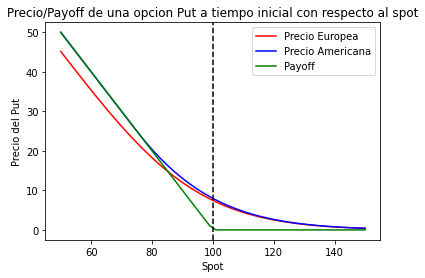

Precio Opcion Europea:  7.446588910777644
Precio Opcion Americana:  7.967099044079217


In [32]:
tipo = "P"

precios_eur = np.zeros(len(S_vec))
precios_ame = np.zeros(len(S_vec))

payoff = np.zeros(len(S_vec))

for index in range(len(S_vec)):
    precios_eur[index] = opcion_europea_bin(tipo, S_vec[index], K, T, r, sigma, div, pasos)
    precios_ame[index] = opcion_americana_bin(tipo, S_vec[index], K, T, r, sigma, div, pasos)
    
    payoff[index] = max(0, K -S_vec[index])

plt.plot(S_vec,precios_eur,'r', label='Precio Europea')
plt.plot(S_vec,precios_ame,'b', label='Precio Americana')

plt.plot(S_vec,payoff,'g', label='Payoff')
plt.axvline(x=K, color = 'black', linestyle='--')

plt.legend()

plt.xlabel('Spot')
plt.ylabel('Precio del Put')
plt.title('Precio/Payoff de una opcion Put a tiempo inicial con respecto al spot')

plt.show()


print("Precio Opcion Europea: ", opcion_europea_bin(tipo, S, K, T, r, sigma, div, pasos))
print("Precio Opcion Americana: ", opcion_americana_bin(tipo, S, K, T, r, sigma, div, pasos))


### CALL con dividendos

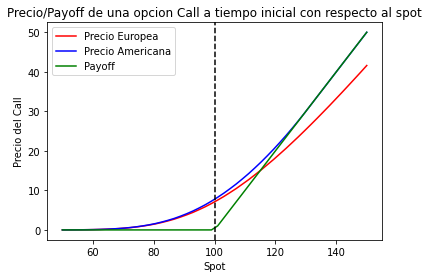

Precio Opcion Europea:  7.083414484093169
Precio Opcion Americana:  7.74420234891751


In [33]:
tipo = "C"

div = 0.1

precios_eur = np.zeros(len(S_vec))
precios_ame = np.zeros(len(S_vec))

payoff = np.zeros(len(S_vec))

for index in range(len(S_vec)):
    precios_eur[index] = opcion_europea_bin(tipo, S_vec[index], K, T, r, sigma, div, pasos)
    precios_ame[index] = opcion_americana_bin(tipo, S_vec[index], K, T, r, sigma, div, pasos)
    
    payoff[index] = max(0, S_vec[index]-K)

plt.plot(S_vec,precios_eur,'r', label='Precio Europea')
plt.plot(S_vec,precios_ame,'b', label='Precio Americana')

plt.plot(S_vec,payoff,'g', label='Payoff')
plt.axvline(x=K, color = 'black', linestyle='--')

plt.legend()

plt.xlabel('Spot')
plt.ylabel('Precio del Call')
plt.title('Precio/Payoff de una opcion Call a tiempo inicial con respecto al spot')

plt.show()


print("Precio Opcion Europea: ", opcion_europea_bin(tipo, S, K, T, r, sigma, div, pasos))
print("Precio Opcion Americana: ", opcion_americana_bin(tipo, S, K, T, r, sigma, div, pasos))

### PUT con dividendos

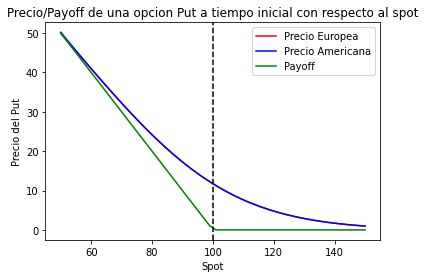

Precio Opcion Europea:  11.722615130567634
Precio Opcion Americana:  11.722837498895863


In [34]:
tipo = "P"

div = 0.1

precios_eur = np.zeros(len(S_vec))
precios_ame = np.zeros(len(S_vec))

payoff = np.zeros(len(S_vec))

for index in range(len(S_vec)):
    precios_eur[index] = opcion_europea_bin(tipo, S_vec[index], K, T, r, sigma, div, pasos)
    precios_ame[index] = opcion_americana_bin(tipo, S_vec[index], K, T, r, sigma, div, pasos)
    
    payoff[index] = max(0, K -S_vec[index])

plt.plot(S_vec,precios_eur,'r', label='Precio Europea')
plt.plot(S_vec,precios_ame,'b', label='Precio Americana')

plt.plot(S_vec,payoff,'g', label='Payoff')
plt.axvline(x=K, color = 'black', linestyle='--')

plt.legend()

plt.xlabel('Spot')
plt.ylabel('Precio del Put')
plt.title('Precio/Payoff de una opcion Put a tiempo inicial con respecto al spot')

plt.show()


print("Precio Opcion Europea: ", opcion_europea_bin(tipo, S, K, T, r, sigma, div, pasos))
print("Precio Opcion Americana: ", opcion_americana_bin(tipo, S, K, T, r, sigma, div, pasos))

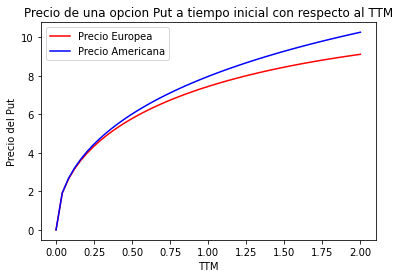

Precio Opcion Europea:  7.446588910777644
Precio Opcion Americana:  7.967099044079217


In [35]:
div = 0
tipo = "P"
r = 0.05

precios_eur = np.zeros(len(T_vec))
precios_ame = np.zeros(len(T_vec))



for index in range(1,len(T_vec)):
    precios_eur[index] = opcion_europea_bin(tipo, S, K, T_vec[index], r, sigma, div, pasos)
    precios_ame[index] = opcion_americana_bin(tipo, S, K, T_vec[index], r, sigma, div, pasos)
    
    payoff[index] = max(0, S_vec[index]-K)

plt.plot(T_vec,precios_eur,'r', label='Precio Europea')
plt.plot(T_vec,precios_ame,'b', label='Precio Americana')

plt.legend()

plt.xlabel('TTM')
plt.ylabel('Precio del Put')
plt.title('Precio de una opcion Put a tiempo inicial con respecto al TTM')

plt.show()


print("Precio Opcion Europea: ", opcion_europea_bin(tipo, S, K, T, r, sigma, div, pasos))
print("Precio Opcion Americana: ", opcion_americana_bin(tipo, S, K, T, r, sigma, div, pasos))

## 4) Black Scholes

Si llegamos hasta aca, entonces estamos en condiciones de ver la formula de Black Scholes. Veremos el modelo en la Clase 4

In [36]:
tipo = "C"
K = 100
T = 1
r = 0.05
sigma= 0.25
div =0

from scipy.stats import norm


In [37]:


#Defino los ds
d1 = (math.log(S / K) + (r - div + 0.5 * sigma * sigma) * T) / sigma / math.sqrt(T)
d2 = (math.log(S / K) + (r - div - 0.5 * sigma * sigma) * T) / sigma / math.sqrt(T)

if tipo == "C":
    precio_BS = math.exp(-div*T) *S * norm.cdf(d1) - K * math.exp(-r * T) * norm.cdf(d2)
elif tipo == "P":
    precio_BS = K * math.exp(-r * T) * norm.cdf(-d2) - math.exp(-div*T) * S * norm.cdf(-d1)
    
precio_BS    

12.335998930368717

## Convergencia del Binomial hacia el precio de Black Scholes

In [38]:
tipo = "P"
S = 100
K = 100
T = 1
r = 0.05
sigma= 0.25
div =0.2

pasos_vec = [1,2,3,4,5,6,7,8,9,10,12,14,16,18,20,25,30,40,50,75,100,125,150,200,250,300]      
precios = np.zeros(len(pasos_vec))

for index in range(len(pasos_vec)):
    precios[index] = opcion_europea_bin(tipo, S, K, T, r, sigma, div, pasos_vec[index])
 
precio_BS = opcion_europea_bs(tipo, S, K, T, r, sigma, div)



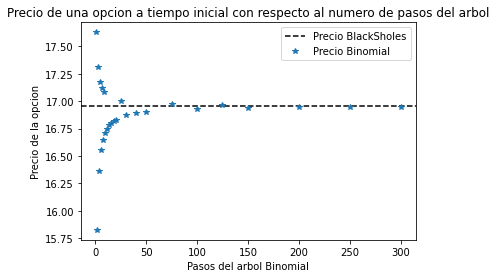

In [39]:
plt.axhline(y=precio_BS, color = 'black', linestyle='--', label='Precio BlackSholes')
plt.plot(pasos_vec,precios,'*', label='Precio Binomial')

plt.legend()

plt.xlabel('Pasos del arbol Binomial')
plt.ylabel('Precio de la opcion')
plt.title('Precio de una opcion a tiempo inicial con respecto al numero de pasos del arbol')

plt.show()

## Convergencia del Binomial (con Americana) hacia el precio de Black Scholes

In [40]:
tipo = "P"
S = 100
K = 100
T = 1
r = 0.05
sigma= 0.25
div =0.

pasos_vec = [1,2,3,4,5,6,7,8,9,10,12,14,16,18,20,25,30,40,50,75,100,125,150,200,250,300]      
precios_eur = np.zeros(len(pasos_vec))
precios_ame = np.zeros(len(pasos_vec))


for index in range(len(pasos_vec)):
    precios_eur[index] = opcion_europea_bin(tipo, S, K, T, r, sigma, div, pasos_vec[index])
    precios_ame[index] = opcion_americana_bin(tipo, S, K, T, r, sigma, div, pasos_vec[index])
 
precio_BS = opcion_europea_bs(tipo, S, K, T, r, sigma, div)



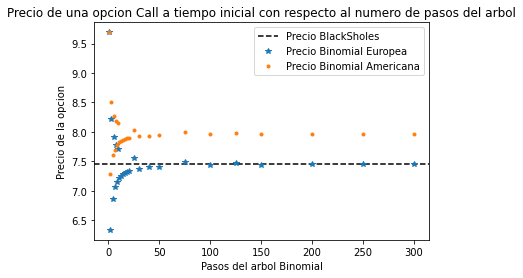

In [41]:
plt.axhline(y=precio_BS, color = 'black', linestyle='--', label='Precio BlackSholes')
plt.plot(pasos_vec,precios_eur,'*', label='Precio Binomial Europea')
plt.plot(pasos_vec,precios_ame,'.', label='Precio Binomial Americana')

plt.legend()

plt.xlabel('Pasos del arbol Binomial')
plt.ylabel('Precio de la opcion')
plt.title('Precio de una opcion Call a tiempo inicial con respecto al numero de pasos del arbol')

plt.show()

## 5) Mercado VS Modelo
## a) Saco una opcion del mercado y calculo su precio - NYSE

In [46]:
# Tomo un ticker e invoco al codigo de la clase pasada

from Codigo.data_nyse import *
ticker = 'TSLA'
data = yf.Ticker(ticker)
#Genero el panel
panel_opciones = obtener_panel_opciones_nyse(ticker, True)



c:\Users\manue\OneDrive\Documents\finanzasCuantitativas\Notebooks\..\Codigo\data_nyse.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  calls = calls.append(data.option_chain(vencimiento)[0])
c:\Users\manue\OneDrive\Documents\finanzasCuantitativas\Notebooks\..\Codigo\data_nyse.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  puts = puts.append(data.option_chain(vencimiento)[1])
c:\Users\manue\OneDrive\Documents\finanzasCuantitativas\Notebooks\..\Codigo\data_nyse.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  calls = calls.append(data.option_chain(vencimiento)[0])
c:\Users\manue\OneDrive\Documents\finanzasCuantitativas\Notebooks\..\Codigo\data_nyse.py:21: FutureWarning: The frame.append method is deprecated and 

In [47]:
panel_opciones

,Especie,Ticker,Spot,CallPut,Strike,TTM,Last,Moneyness,impliedVolatility,Bid,Ask
0,TSLA220819C00050000,TSLA,910.202393,C,50.0,1,866.95,18.204048,20.691410,861.80,863.35
1,TSLA220819P00050000,TSLA,910.202393,P,50.0,1,0.01,18.204048,0.500005,0.00,0.00
2,TSLA220819C00100000,TSLA,910.202393,C,100.0,1,816.35,9.102024,15.093751,811.65,813.05
3,TSLA220819P00100000,TSLA,910.202393,P,100.0,1,0.01,9.102024,0.500005,0.00,0.00
4,TSLA220819C00150000,TSLA,910.202393,C,150.0,1,765.70,6.068016,12.402346,761.80,763.35
...,...,...,...,...,...,...,...,...,...,...,...
4778,TSLA240621P02200000,TSLA,910.202393,P,2200.0,673,1300.02,0.413728,0.383078,1293.95,1302.75
4779,TSLA240621C02250000,TSLA,910.202393,C,2250.0,673,74.80,0.404534,0.598904,72.00,75.85
4780,TSLA240621P02250000,TSLA,910.202393,P,2250.0,673,1350.97,0.404534,0.375990,1340.35,1350.40
4781,TSLA240621C02275000,TSLA,910.202393,C,2275.0,673,72.50,0.400089,0.598679,69.95,74.55


In [48]:
# Tomo los TTMs y me quedo con alguno de ellos
TTMs = list(set(panel_opciones.TTM.values))
TTMs.sort()

TTM=TTMs[4]
TTM

29

In [49]:
# elijo un tipo de opcion y tomo los strikes
CP = "P"
Ks = panel_opciones[(panel_opciones.TTM == TTM) & (panel_opciones.CallPut == CP)].Strike.values
Ks_indexes = panel_opciones[(panel_opciones.TTM == TTM) & (panel_opciones.CallPut == CP)].Strike.index

Ks_indexes

Int64Index([1202, 1204, 1206, 1208, 1210, 1212, 1214, 1216, 1218, 1220,
            ...
            1787, 1789, 1792, 1795, 1797, 1799, 1801, 1803, 1807, 1809],
           dtype='int64', length=301)

In [50]:
#Tomo el ATM strike
K_atm_index = np.abs(Ks - panel_opciones.Spot.values[0]).argmin()

K_ATM = Ks[K_atm_index]
K_ATM
K_ATM_index_df = panel_opciones[(panel_opciones.TTM == TTM) & (panel_opciones.CallPut == CP)&(panel_opciones.Strike==K_ATM)].Strike.index[0]
K_ATM_index_df


1506

In [51]:
panel_opciones[panel_opciones.index==543]

,Especie,Ticker,Spot,CallPut,Strike,TTM,Last,Moneyness,impliedVolatility,Bid,Ask
543,TSLA220826P00910000,TSLA,910.202393,P,910.0,8,27.87,1.000222,0.485296,27.65,27.9


In [52]:
# Saco de los datos de mercado los parametros necesarios para pricear


CP = 'P'
S = panel_opciones.Spot.values[K_ATM_index_df]

K = panel_opciones.Strike.values[K_ATM_index_df]
T = (panel_opciones.TTM.values[K_ATM_index_df])/365

sigma = panel_opciones.impliedVolatility.values[K_ATM_index_df]

#sigma = panel_opciones[(panel_opciones.TTM == TTM) & (panel_opciones.CallPut == CP) & (panel_opciones.Strike == K_ATM)].impliedVolatility.values[0]
try:
    div = float(data.info['dividendYield'])
except:
    div = 0.0 
    
pasos = 2000




In [53]:
div


0.0

In [54]:
#tasa libre de riesgo de Libor1M - https://www.global-rates.com/en/interest-rates/libor/libor.aspx
r = 0.00084  #Libor1M**

   

In [55]:
# Volatilidad sacada del dataframe
sigma

0.4880727462768555

In [56]:
# dividendo sacada de data.info
div

0.0

In [57]:
#spot sacada de data.info
S

910.202392578125

In [58]:
# Llamo a los 2 pricers y comparo con el precio de mercado

precio_modelo_bin = opcion_americana_bin(CP, S, K, T, r, sigma, div, pasos)
print("Precio Modelo Binomial: ", precio_modelo_bin)

precio_modelo_bs = opcion_europea_bs(CP, S, K, T, r, sigma, div)
print("Precio Modelo BS: ", precio_modelo_bs)

precio_mercado_last = panel_opciones[(panel_opciones.TTM == TTM) & (panel_opciones.CallPut == CP) & (panel_opciones.Strike == K_ATM)].Last.values[0] 

precio_mercado_avg = (panel_opciones[(panel_opciones.TTM == TTM) & (panel_opciones.CallPut == CP) & (panel_opciones.Strike == K_ATM)].Bid.values[0]#
+panel_opciones[(panel_opciones.TTM == TTM) & (panel_opciones.CallPut == CP) & (panel_opciones.Strike == K_ATM)].Ask.values[0]
)/2

print("Precio Mercado Last: ", precio_mercado_last)

print("Precio Mercado Avg: ", precio_mercado_avg)



Precio Modelo Binomial:  49.775182908887565
Precio Modelo BS:  49.77767863529891
Precio Mercado Last:  50.95
Precio Mercado Avg:  50.650000000000006


In [59]:
#Error relativo entre valor de mercado y valor de modelo:

print("Error relativo entre modelo y mercado (en %): ", (precio_mercado_avg-precio_modelo_bs)/precio_mercado_avg*100)

Error relativo entre modelo y mercado (en %):  1.7222534347504315


## b) Saco una opcion del mercado y calculo su precio - BYMA


## Ejercicio